In [559]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel
from torch.autograd import Variable 
from tqdm.autonotebook import trange
import sklearn.metrics as metrica
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

Создаём эмбеддинги с помощью RuBERT.

In [773]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()
def get_embedding(frame):
    tmp = frame.copy()
    def embed(row):
        return embed_bert_cls(row['sentence'], model, tokenizer)
    tmp['embed'] = tmp[['sentence']].apply(embed, axis=1)
    df = tmp[['id','embed', 'sentiment', '1category']]
    return df
df = pd.read_csv('/home/jupyter/mnt/s3/datahack/train.csv')
df = df.rename(columns={'Unnamed: 0': 'id'})
replace_map = {'+': 1, '−': -1, '?': 0}
df['sentiment'] = df['sentiment'].replace(replace_map)
train_df = df.loc[:, ['id', 'sentence','sentiment', '1category']]
sentence_tokenisation = get_embedding(train_df)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Загрузим из объектного хранилища данные и посмотрим на их распределение. Для сантиментов распределение хорошее. Для категорий очень много неопределенных значений и мало данных для **Safety** и **Price**. Это плохо.

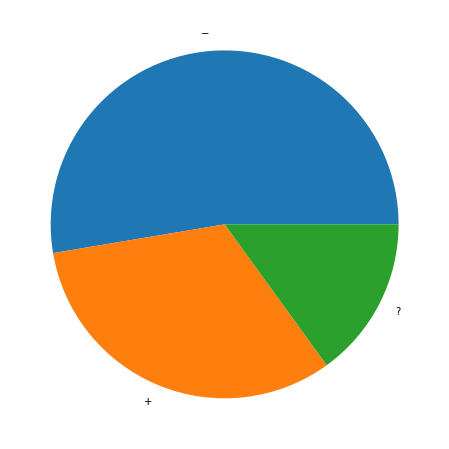

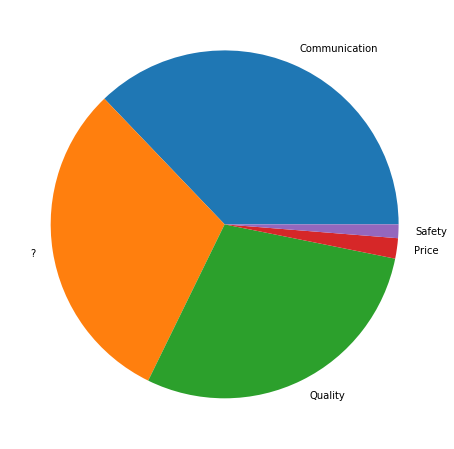

In [903]:
data = pd.read_csv('/home/jupyter/mnt/s3/datahack/train.csv')
plt.figure(figsize=(8, 8))
plt.pie(data['sentiment'].value_counts(), labels=data['sentiment'].value_counts().index)
plt.savefig('Pasha/Figures/snt_pie.png', dpi=300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(8, 8))
plt.pie(data['1category'].value_counts(), labels=data['1category'].value_counts().index)
plt.savefig('Pasha/Figures/cat_pie.png', dpi=300, bbox_inches='tight');

Создаём обучающий и тестовый датасеты.

In [774]:
data = data.rename(columns={'Unnamed: 0': 'id'})

replace_map = {'+': 2, '−': 0, '?': 1}
data['sentiment'] = data['sentiment'].replace(replace_map)

rm = {'Communication' : 0, 'Price' : 1, 'Quality' : 2, 'Safety' : 3}
data['1category'] = data['1category'].replace(rm)
data_cat = data[data['1category'] != '?']

In [775]:
y_cat = np.array(data_cat['1category'])
y_snt = data['sentiment']
X = sentence_tokenisation['embed']
X_cat = sentence_tokenisation['embed'][sentence_tokenisation['1category']!='?']
X = np.array(X)
X_cat = np.array(X_cat)
X_cat = np.array([np.array(X_cat[i]) for i in range(X_cat.shape[0])])
X = np.array([np.array(X[i]) for i in range(X.shape[0])])
y_snt = np.array([np.array(y_snt[i]) for i in range(y_snt.shape[0])])
y_cat = np.array([np.array(y_cat[i]) for i in range(y_cat.shape[0])])

In [816]:
batch_size = 512

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y_snt, test_size=0.25, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cat, y_cat, test_size=0.25, random_state=42)

Xs_train_t = torch.from_numpy(Xs_train).to(torch.float32)
ys_train_t = torch.from_numpy(ys_train).to(torch.long)
Xs_test_t = torch.from_numpy(Xs_test).to(torch.float32)
ys_test_t = torch.from_numpy(ys_test).to(torch.long)

Xc_train_t = torch.from_numpy(Xc_train).to(torch.float32)
yc_train_t = torch.from_numpy(yc_train).to(torch.long)
Xc_test_t = torch.from_numpy(Xc_test).to(torch.float32)
yc_test_t = torch.from_numpy(yc_test).to(torch.long)

train_dataset_s = TensorDataset(Xs_train_t, ys_train_t)
test_dataset_s = TensorDataset(Xs_test_t, ys_test_t)

train_dataset_c = TensorDataset(Xc_train_t, yc_train_t)
test_dataset_c = TensorDataset(Xc_test_t, yc_test_t)

train_dataloader_s = DataLoader(train_dataset_s, batch_size=batch_size, drop_last=True)
test_dataloader_s = DataLoader(test_dataset_s, batch_size=batch_size, drop_last=True)

train_dataloader_c = DataLoader(train_dataset_c, batch_size=batch_size, drop_last=True)
test_dataloader_c = DataLoader(test_dataset_c, batch_size=batch_size, drop_last=True)


loaders_c = {"train": train_dataloader_c, "test" : test_dataloader_c}
loaders_s = {"train": train_dataloader_s, "test" : test_dataloader_s}

Инициализируем модели. Для сантиментов и категорий отдельно. Помимо MLP были реализованы также CNN и LSTM, но они показали худшие результаты (код моделей оставлен). Также в другом ноутбуке (участником Артёмом Подвальным) было реализовано обучение CatBoost. Поклассовое сравнение метрики ROC AUC приведено в презентации.

In [874]:
activation = nn.LeakyReLU
in_features = 312
out_features = 4
improve = nn.Dropout

classifier_cat = nn.Sequential(
    improve(0.1),
    nn.Linear(in_features, 128),
    activation(),
    improve(0.2),
    nn.Linear(128, 64),
    activation(),
    improve(0.25),
    nn.Linear(64, 32),
    activation(),
    nn.Linear(32, out_features),
)

In [875]:
activation = nn.LeakyReLU
in_features = 312
out_features = 3

classifier_snt = nn.Sequential(
    improve(0.1),
    nn.Linear(in_features, 128),
    activation(),
    improve(0.2),
    nn.Linear(128, 64),
    activation(),
    improve(0.25),
    nn.Linear(64, 32),
    activation(),
    nn.Linear(32, out_features),
)

In [591]:
conv = nn.Sequential(
    nn.Conv1d(1, 6, 3, padding=1),
    nn.BatchNorm1d(6),
    nn.MaxPool1d(2, 2),
    nn.Conv1d(6, 12, 3, padding=1),
    nn.BatchNorm1d(12),
    nn.MaxPool1d(2, 2),
    nn.Conv1d(12, 16, 3, padding=1),
    nn.BatchNorm1d(16),
    nn.MaxPool1d(2, 2),    
)


In [592]:
class CNN(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv = conv
        self.mlp = nn.Sequential(
            nn.Linear(624, 128),
            activation(),
            improve(0.2),
            nn.Linear(128, 64),
            activation(),
            improve(0.3),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, out_features),
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, -1)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        return x
        
cnn_cat = CNN(5)
cnn_snt = CNN(3)

In [584]:

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = x.view(x.shape[0], 1, -1)
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    
    
lstm_c = LSTM1(5, 312, 128, 1, 2)
lstm_s = LSTM1(3, 312, 128, 1, 2)

In [704]:
def num_to_vec(x, shape):
    res = torch.zeros(len(x), shape)
    for i in range(len(res)):
        res[i, x[i]] = 1
        
    return res

Функция training loop:

In [876]:
def training_loop(model, criterion, optimizer, loaders, max_epochs, shape=3, scheduler=None, save=(-1, None), device='cpu'):
    
    accuracy = {"train": [], "test" : []}
    loss_history = {"train": [], "test" : []}
    mean_loss = {"train": [], "test" : []}
    ROC_AUC = {"train": [], "test" : []}
    mean_ROC_AUC = {"train": [], "test" : []}
    mean_acc = {"train": [], "test" : []}

    for epoch in trange(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        
                y_pred = F.softmax(outp, 1)
                preds = torch.round(y_pred)
                correct = 0

                
#                 row_sums = torch.sum(y_pred, 1) # normalization 
#                 row_sums = row_sums.repeat(1, shape) # expand to same size as out
#                 row_sums = row_sums.view(y_pred.shape)
#                 y_pred = torch.div(y_pred , row_sums) # these should be histograms

                for i in range(len(preds)):

                    if torch.argmax(preds[i]) == y_batch[i]:
                        correct += 1
                all =  len(preds)
                epoch_correct += correct
                epoch_all += all
                
                loss = criterion(outp, y_batch)
                loss_history[k].append(loss.to('cpu').detach().numpy())
                
                y_score = num_to_vec(y_batch, shape)
                auc = []
                acc = []
                for i in range(shape):
                    auc_score = metrica.roc_auc_score(y_score[:, i].cpu().detach(), y_pred[:, i].cpu().detach())
                    acc_score = metrica.accuracy_score(y_score[:, i].cpu().detach(), preds[:, i].cpu().detach())
                    auc.append(auc_score)
                    acc.append(auc_score)
                    
                #auc_score = metrica.roc_auc_score(y_batch.cpu().detach(), y_pred.cpu().detach(), multi_class='ovr')
                ROC_AUC[k].append(auc)
                #ROC_AUC[k].append(metrica.roc_auc_score(y_batch.to('cpu').detach().numpy(), y_pred.to('cpu').detach().numpy(), multi_class='ovo'))
                
                if k == "train":
                    loss.backward()
                    optimizer.step()
    
            
            #print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(acc)
            
            epoch_loss = np.array(loss_history[k])
            epoch_RA = np.array(ROC_AUC[k])
            epoch_acc = np.array(accuracy[k])
            loss_history[k] = []
            ROC_AUC[k] = []
            accuracy[k] = []
            
            mean_loss[k].append(np.mean(epoch_loss))
            mean_ROC_AUC[k].append(epoch_RA.T.mean(axis=1))
            mean_acc[k].append(epoch_acc.T.mean(axis=1))
            
            scheduler.step()

   

        av_roc = round(np.mean(mean_ROC_AUC['test']), 5)
        if save[0] != -1 and epoch % save[0] == 0 and epoch > 0 or epoch == max_epochs - 1:
            with open(f'{save[1]}_epoch_{epoch}_auroc_{av_roc}.pt', 'wb+') as f:
                torch.save(model.state_dict(), f)
                
    metrics = {
        'Accuracy' : mean_acc,
        'ROC_AUC' : mean_ROC_AUC,
        'Loss' : mean_loss
    }     
    
    return metrics

Обучаем наши модели:

In [877]:
device = 'cpu'

criterion = nn.CrossEntropyLoss() 

optimizer_cat = torch.optim.Adam(classifier_cat.parameters(), lr=0.003)
optimizer_snt = torch.optim.Adam(classifier_snt.parameters(), lr=0.003)
scheduler_cat = lr_scheduler.StepLR(optimizer_cat, step_size=5, gamma=0.9)
scheduler_snt = lr_scheduler.StepLR(optimizer_snt, step_size=5, gamma=0.9)

max_epochs = 100
save_c = (10, 'Pasha/models/cat')
save_s = (10, 'Pasha/models/snt')

metrics_cat = training_loop(classifier_cat, criterion, optimizer_cat, loaders_c, max_epochs, shape=4, scheduler=scheduler_cat, save=save_c, device=device)
metrics_snt = training_loop(classifier_snt, criterion, optimizer_snt, loaders_s, max_epochs, shape=3, scheduler=scheduler_snt, save=save_s, device=device)

In [462]:
optimizer_cat = torch.optim.Adam(cnn_cat.parameters(), lr=0.001)
optimizer_snt = torch.optim.Adam(cnn_snt.parameters(), lr=0.001)
max_epochs = 30

metrics_cat_cnn = training_loop(cnn_cat, criterion, optimizer_cat, loaders_c, max_epochs, shape=5, save=save_c, device=device)
metrics_snt_cnn = training_loop(cnn_snt, criterion, optimizer_snt, loaders_s, max_epochs, shape=3, save=save_s, device=device)

Отрисовка графиков лосса и метрик для моделей:

In [810]:
def get_plot(metric, labels, name):
    
    metrics = {'Loss', 'Accuracy', 'ROC_AUC'}
    
    for mode in metrics:
        plt.figure(figsize=(12, 7))
        plt.title('Train ' + mode)
        if mode in {'Accuracy', 'ROC_AUC'}:
            for i in range(len(labels)):
                plt.plot(np.array(metric[mode]['train'])[:,i], label=labels[i])
            plt.legend()
        else:
            plt.plot(metric[mode]['train'])
        plt.xlabel('epoch')
        plt.savefig(f'Pasha/Figures/{mode}_train_{name}.png', dpi=300, bbox_inches='tight')

        plt.figure(figsize=(12, 7))
        plt.title('Test ' + mode)
        if mode in {'Accuracy', 'ROC_AUC'}:
            for i in range(len(labels)):
                plt.plot(np.array(metric[mode]['test'])[:, i], label=labels[i])
            plt.legend()
        else:
            plt.plot(metric[mode]['test'])
        plt.xlabel('epoch')
        plt.savefig(f'Pasha/Figures/{mode}_test_{name}.png', dpi=300, bbox_inches='tight')

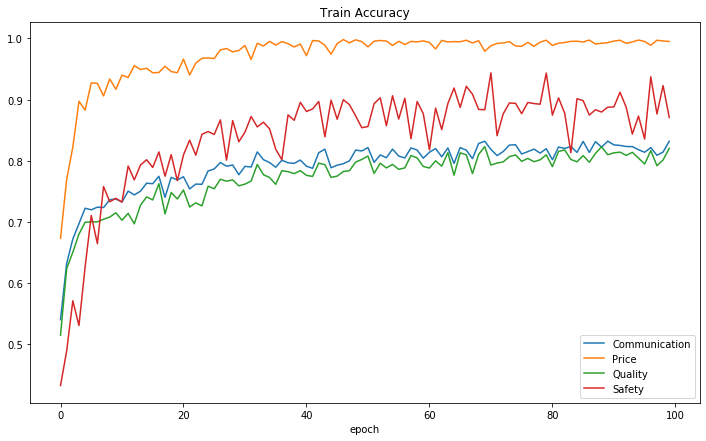

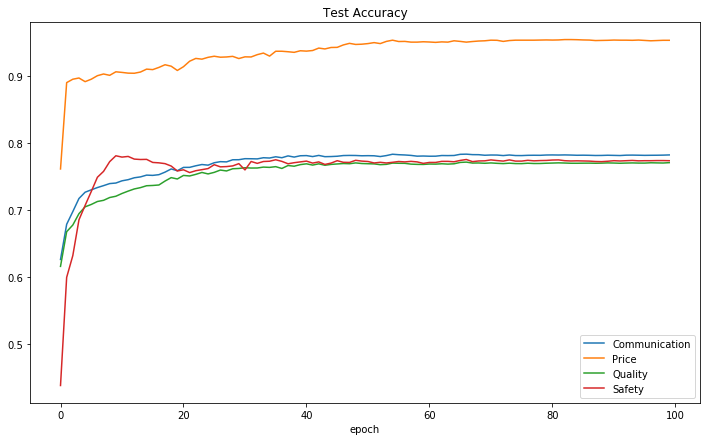

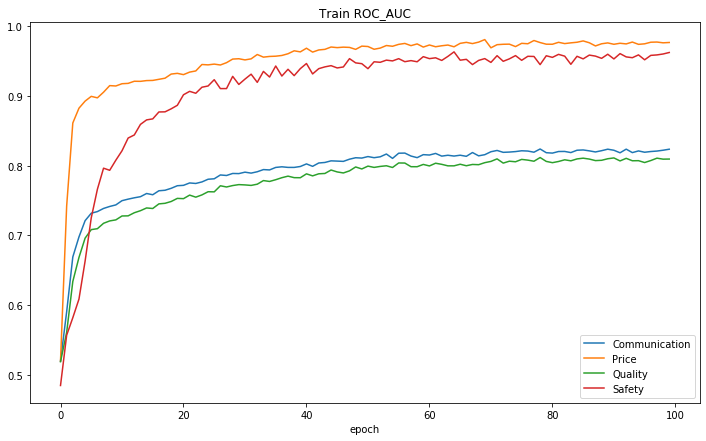

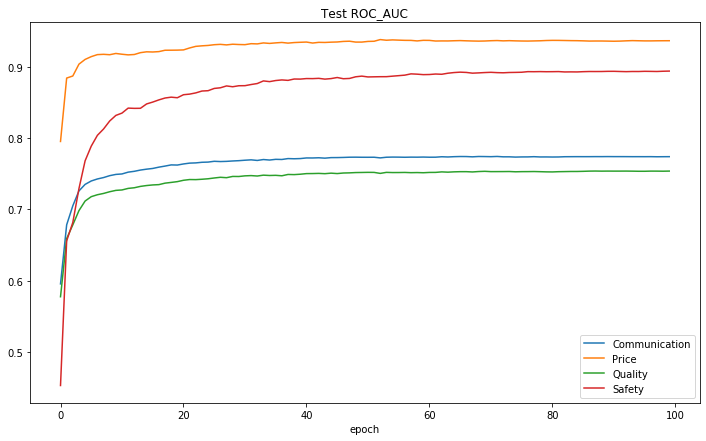

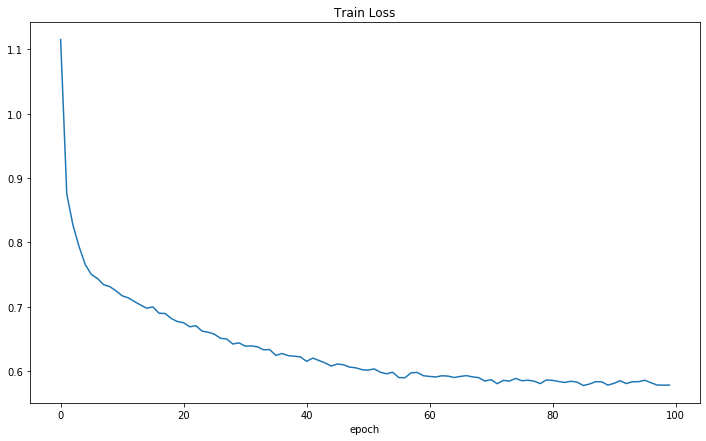

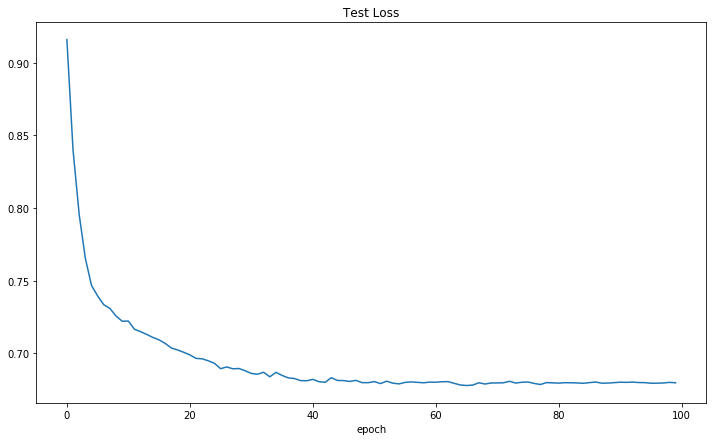

In [878]:
labels = ['Communication', 'Price', 'Quality', 'Safety']
get_plot(metrics_cat, labels, 'cat_sm') # Графики для категорий

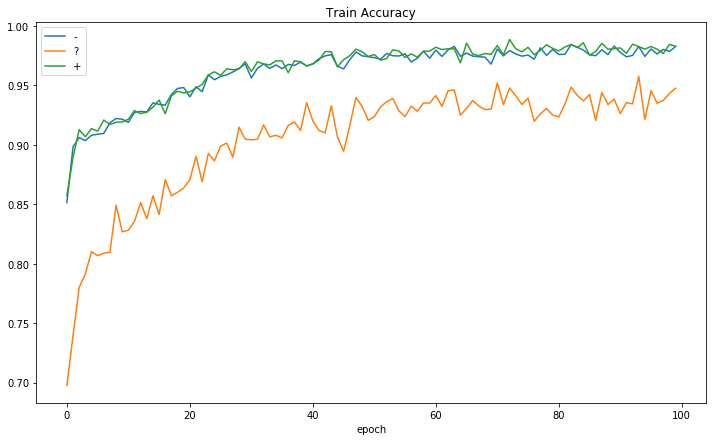

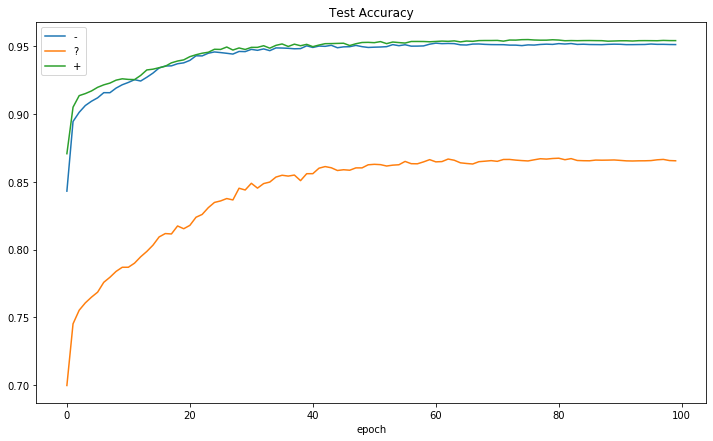

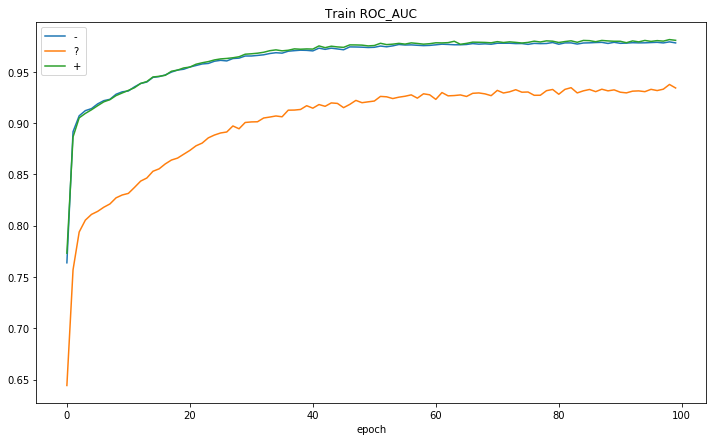

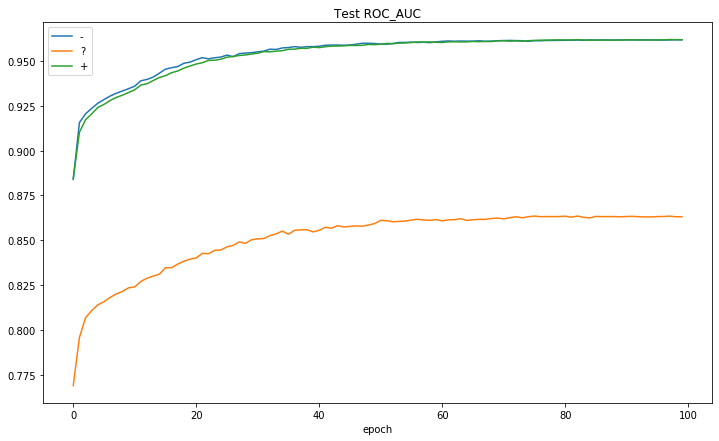

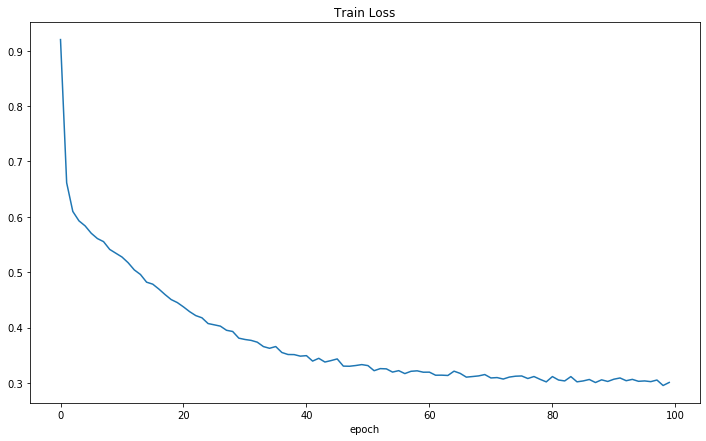

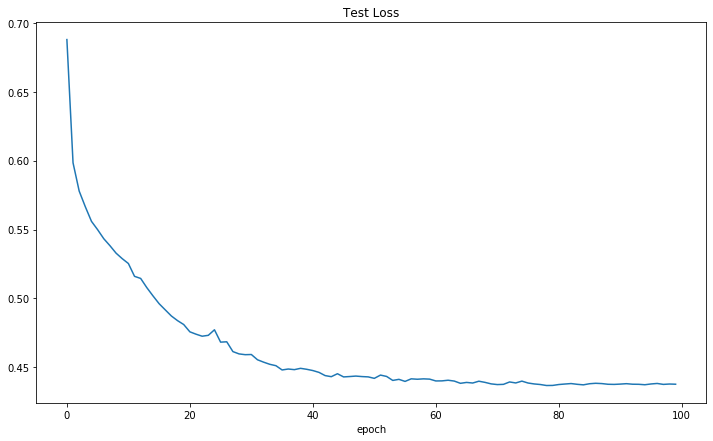

In [879]:
labels = ['-', '?', '+']
get_plot(metrics_snt, labels, 'snt_sm') # Графики для сантимента

Посмотрим на результаты работы модели: посчитаем confusion matrix для сантимента и для категорий. Для сантимента всё хорошо, а вот для категрий всё не очень (подробности -- на нашем выступлении))

In [904]:
y_pred = []
y_true = []
classifier_snt.eval()
for x, y in test_dataset_s:
    y_true.append(y)
    y_pred.append(torch.argmax(classifier_snt(x)))

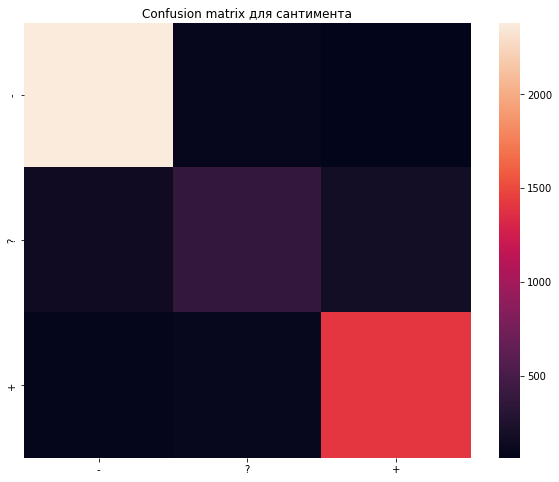

In [905]:
plt.figure(figsize=(10,8))
sns.heatmap(metrica.confusion_matrix(y_true, y_pred))
plt.title('Confusion matrix для сантимента')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['-', '?', '+'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['-', '?', '+'])
plt.savefig('Pasha/Figures/snt_confmat.png', dpi=300, bbox_inches='tight');

In [906]:
y_pred = []
y_true = []
classifier_cat.eval()
for x, y in test_dataset_s:
    y_true.append(y)
    y_pred.append(torch.argmax(classifier_cat(x)))
    

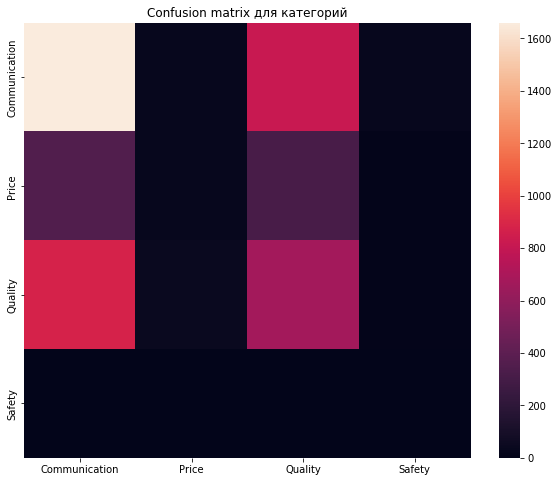

In [908]:
plt.figure(figsize=(10,8))
sns.heatmap(metrica.confusion_matrix(y_true, y_pred))
plt.title('Confusion matrix для категорий')
plt.xticks(ticks=np.arange(4)+0.5, labels=['Communication', 'Price', 'Quality', 'Safety'])
plt.yticks(ticks=np.arange(4)+0.5, labels=['Communication', 'Price', 'Quality', 'Safety']);
plt.savefig('Pasha/Figures/cat_confmat.png', dpi=300, bbox_inches='tight');

И, наконец, проведём сабмит конкурсных данных.

In [890]:
def get_embedding(frame):
    tmp = frame.copy()
    def embed(row):
        return embed_bert_cls(row['texts'], model, tokenizer)
    tmp['embed'] = tmp[['texts']].apply(embed, axis=1)
    df = tmp[['id','embed']]
    return df

df = pd.read_csv('Pasha/new_test.csv')
df = df.rename(columns={'Unnamed: 0': 'id'})

sentence_tokenisation = get_embedding(df)

x = torch.tensor(sentence_tokenisation['embed'])

with torch.no_grad():
    classifier_snt.eval()
    classifier_cat.eval()
    snt = classifier_snt(x)
    cat = classifier_cat(x)

In [891]:
snt = torch.softmax(snt, 1)
cat = torch.softmax(cat, 1)

In [893]:
df['+'] = snt[:, 2]
df['-'] = snt[:, 0]
df['?'] = snt[:, 1]

In [894]:
df['Communication'] = cat[:, 0]
df['Quality'] = cat[:, 2]
df['Price'] = cat[:, 1]
df['Safety'] = cat[:, 3]

In [897]:
df = df.rename(columns={'id': 'Unnamed: 0'})
df.to_csv('Pasha/submit.csv')

In [898]:
df

,Unnamed: 0,texts,+,-,?,Communication,Quality,Price,Safety
0,4036,15.03.2022 обратился на горячую линию для закр...,0.025125,0.076210,0.898666,0.533903,0.453635,0.005917,0.006545
1,5804,"Уже который год в ТКБ не решается ""глобальная ...",0.002420,0.967388,0.030192,0.100158,0.898715,0.000730,0.000397
2,2752,Добрый день. Хочу оставить отзыв о пользовании...,0.786377,0.034574,0.179049,0.148408,0.779087,0.062380,0.010125
3,1921,"Добрый день Сегодня, зайдя в свой личный кабин...",0.035114,0.888727,0.076159,0.450335,0.548382,0.000245,0.001038
4,7374,"Обслуживаюсь в Тинькофф пару лет, возникла жес...",0.013749,0.951209,0.035042,0.496991,0.471341,0.022887,0.008781
...,...,...,...,...,...,...,...,...,...
995,146,Отвратительный сервис и отношение к клиентам! ...,0.359997,0.565541,0.074462,0.359686,0.613099,0.020795,0.006421
996,2677,28.04.2022 обратилась в банк о возможности пер...,0.006353,0.052691,0.940956,0.573435,0.248262,0.175813,0.002490
997,4481,В начале 2021 года была акция по выплате 8% ке...,0.051250,0.381403,0.567347,0.163349,0.722630,0.107643,0.006379
998,4112,Бездействие банка и некомпетентность сотрудник...,0.005177,0.926440,0.068383,0.633554,0.295080,0.009683,0.061683
